In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [3]:
final_df = pd.read_csv("../create_datasets/final_transition_out_of_poss_df.csv")
team_ids = final_df['uniqueTeamId']

In [4]:
final_df

,uniqueTeamId,Air duel_Zone_1,Air duel_Zone_2,Air duel_Zone_3,Foul_Zone_1,Foul_Zone_2,Foul_Zone_3,Ground attacking duel_Zone_1,Ground attacking duel_Zone_2,Ground attacking duel_Zone_3,...,Zone_2_Run,Zone_3_Run,Backward Run,Forward Run,Side Run,Short Run,Middle Run,Long Run,average_acceleration_length,Forward_Runs_Zone_3
0,10531---2499726,4,6,3,0,3,1,4,19,11,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,27.911288,0.0
1,10531---2499736,4,9,2,2,3,1,10,11,11,...,1.0,1.0,0.0,3.0,0.0,1.0,1.0,1.0,25.469525,1.0
2,10531---2499741,10,4,3,0,3,0,3,13,15,...,4.0,0.0,0.0,3.0,1.0,1.0,2.0,1.0,34.351247,0.0
3,10531---2499757,8,4,5,0,1,2,6,11,10,...,1.0,0.0,0.0,3.0,1.0,1.0,0.0,3.0,43.278582,0.0
4,10531---2499766,4,9,6,2,1,1,9,11,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,756---2565880,5,4,10,1,4,2,7,14,27,...,4.0,1.0,0.0,6.0,0.0,2.0,2.0,2.0,26.437137,1.0
3648,756---2565892,2,7,4,2,8,3,3,21,10,...,5.0,1.0,0.0,7.0,0.0,2.0,3.0,2.0,30.048182,1.0
3649,756---2565904,13,14,3,2,2,1,13,13,12,...,2.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,26.824966,0.0
3650,756---2565908,5,10,4,0,4,4,4,16,18,...,5.0,1.0,0.0,6.0,1.0,4.0,2.0,1.0,22.850920,1.0


In [5]:
final_df.set_index("uniqueTeamId", inplace = True)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from kmedoids import KMedoids
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import calculate_distance_matrix
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

    # Autoencoder for DEC
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


    # DEC model
class DEC(nn.Module):
    def __init__(self, encoder, cluster_centers):
        super().__init__()
        self.encoder = encoder
        self.clusters = nn.Parameter(cluster_centers)

    def forward(self, x):
        z = self.encoder(x)
        q = 1.0 / (1.0 + torch.sum((z.unsqueeze(1) - self.clusters)**2, dim=2))
        q = q / torch.sum(q, dim=1, keepdim=True)
        return q

# Target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def compute_indices(X, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) == 0:
            cluster_centers.append(np.zeros(X.shape[1]))
        else:
            cluster_centers.append(cluster_points.mean(axis=0))
    cluster_centers = np.array(cluster_centers)

    distances = pairwise_distances(X, cluster_centers)

    # Iwcss: Sum of squared distances to cluster centers
    Iwcss = sum(np.sum((X[labels == i] - cluster_centers[i]) ** 2) for i in range(n_clusters))

    # Isep: Mean distance between all cluster centers
    Isep = np.mean(cdist(cluster_centers, cluster_centers))

    # Idistcc and Idens with filtering for valid clusters
    valid_dists = []
    valid_dens = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        if len(cluster_points) < 2:
            continue  # Skip small clusters to avoid NaN in mean/std
        distances_to_center = np.linalg.norm(cluster_points - cluster_centers[i], axis=1)
        valid_dists.append(np.mean(distances_to_center))
        valid_dens.append(np.std(distances_to_center))

    # Default to 0 if all clusters were invalid
    Idistcc = np.mean(valid_dists) if valid_dists else 0.0
    Idens = np.mean(valid_dens) if valid_dens else 0.0

    return Iwcss, Isep, Idistcc, Idens



def normalize(val, min_val, max_val, larger_is_better):
    range_ = max_val - min_val
    if np.isclose(range_, 0):
        return 1.0  # or 0.5, depending on how you want to treat flat metrics
    if larger_is_better:
        return np.clip((val - min_val) / (range_ + 1e-10), 0, 1)
    else:
        return np.clip(1 - (val - min_val) / (range_ + 1e-10), 0, 1)

In [7]:
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# If using GPU
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_df)

pca2 = PCA(n_components=2)
X_pca = pca2.fit_transform(X_scaled)

# Tensor version for PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Store results
results = []

dec_loss = {}

# Iterate over k values
for k in range(2, 11):
    dec_loss[k] = {'ae_loss' : [], 'kl_loss' : []}
    clusterings = {
        'kmeans': KMeans(n_clusters=k, random_state=42),
        'kmedoids': KMedoids(n_clusters=k, metric='euclidean', init='random', max_iter=300, random_state=42),
        'ward': AgglomerativeClustering(n_clusters=k, linkage='ward')
    }

    for method_name, model in clusterings.items():
        labels = model.fit_predict(X_scaled)
        sil_score = silhouette_score(X_scaled, labels)
        
        Iwcss, Isep, Idistcc, Idens = compute_indices(X_scaled, labels)

        results.append({
            'k': k,
            'method': method_name,
            'silhouette_score': sil_score,
            'Iwcss': Iwcss,
            'Isep': Isep,
            'Idistcc': Idistcc,
            'Idens': Idens
        })
        
        print(results[-1])
        
        
    for method_name, model in clusterings.items():
        labels = model.fit_predict(X_pca)
        sil_score = silhouette_score(X_pca, labels)
        
        Iwcss, Isep, Idistcc, Idens = compute_indices(X_pca, labels)

        results.append({
            'k': k,
            'method': f"{method_name}_pca",
            'silhouette_score': sil_score,
            'Iwcss': Iwcss,
            'Isep': Isep,
            'Idistcc': Idistcc,
            'Idens': Idens
        })
        
        print(results[-1])
        

    # DEC pretrain
    input_dim = X_scaled.shape[1]
    latent_dim = 10
    ae = AutoEncoder(input_dim, latent_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ae.parameters(), lr=1e-3)

    for epoch in range(3000):
        optimizer.zero_grad()
        output = ae(X_tensor)
        loss = criterion(output, X_tensor)
        loss.backward()
        optimizer.step()
        dec_loss[k]['ae_loss'].append(loss)
        

    z = ae.encoder(X_tensor).detach().numpy()
    kmeans = KMeans(n_clusters=k, random_state=42).fit(z)
    initial_cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

    dec = DEC(ae.encoder, initial_cluster_centers.clone())
    dec_optimizer = optim.Adam(dec.parameters(), lr=1e-3)

    for epoch in range(3000):
        q = dec(X_tensor)
        p = target_distribution(q.detach())
        loss = torch.nn.functional.kl_div(q.log(), p, reduction='batchmean')

        dec_optimizer.zero_grad()
        loss.backward()
        dec_optimizer.step()
    
        dec_loss[k]['kl_loss'].append(loss)

    with torch.no_grad():
        z_final = dec.encoder(X_tensor)
        final_q = dec(X_tensor)
        labels = torch.argmax(final_q, dim=1).numpy()
    
    sil_score = silhouette_score(z_final.numpy(), labels)

    Iwcss, Isep, Idistcc, Idens = compute_indices(z_final.numpy(), labels) 

    results.append({
        'k': k,
        'method': 'dec',
        'silhouette_score': sil_score,
        'Iwcss': Iwcss, 
        'Isep': Isep,
        'Idistcc': Idistcc,
        'Idens': Idens
    })

    print(results[-1])

{'k': 2, 'method': 'kmeans', 'silhouette_score': 0.09956437400450587, 'Iwcss': 151511.28629175166, 'Isep': 2.0272867530534215, 'Idistcc': 6.302215568316118, 'Idens': 1.7307383043744358}
{'k': 2, 'method': 'kmedoids', 'silhouette_score': 0.07952701276733751, 'Iwcss': 154220.57880367682, 'Isep': 1.7166016214713515, 'Idistcc': 6.365900051059498, 'Idens': 1.7139523798700633}
{'k': 2, 'method': 'ward', 'silhouette_score': 0.05105144280417534, 'Iwcss': 156011.40960885392, 'Isep': 1.7655628883456638, 'Idistcc': 6.196036391071376, 'Idens': 1.5943773542998139}
{'k': 2, 'method': 'kmeans_pca', 'silhouette_score': 0.3497030208743358, 'Iwcss': 25522.52890103374, 'Isep': 2.023281888415044, 'Idistcc': 2.3392793513956134, 'Idens': 1.3070965637981158}
{'k': 2, 'method': 'kmedoids_pca', 'silhouette_score': 0.33960452665959, 'Iwcss': 25578.59270785394, 'Isep': 1.9627545640194752, 'Idistcc': 2.3377639925800615, 'Idens': 1.3161067517462737}
{'k': 2, 'method': 'ward_pca', 'silhouette_score': 0.324024699995

{'k': 8, 'method': 'kmeans_pca', 'silhouette_score': 0.3210874985068997, 'Iwcss': 6994.34588165618, 'Isep': 4.174947646635486, 'Idistcc': 1.328398352338184, 'Idens': 0.643238790803633}
{'k': 8, 'method': 'kmedoids_pca', 'silhouette_score': 0.30767049482101777, 'Iwcss': 7145.646590981421, 'Isep': 3.896530443310576, 'Idistcc': 1.2764913626668055, 'Idens': 0.636529862753761}
{'k': 8, 'method': 'ward_pca', 'silhouette_score': 0.26560197297287547, 'Iwcss': 8323.572588909059, 'Isep': 4.123078593907691, 'Idistcc': 1.3717779288827487, 'Idens': 0.7295511799849945}
{'k': 8, 'method': 'dec', 'silhouette_score': 0.9629658, 'Iwcss': 7815.844434738159, 'Isep': 32.16054372712121, 'Idistcc': 0.8215729, 'Idens': 1.4326183}
{'k': 9, 'method': 'kmeans', 'silhouette_score': 0.04343665183311511, 'Iwcss': 126178.5429798445, 'Isep': 5.277236593586881, 'Idistcc': 5.828025512529831, 'Idens': 1.5204729047162806}
{'k': 9, 'method': 'kmedoids', 'silhouette_score': 0.019685182133597885, 'Iwcss': 132099.53668302554

In [8]:
# Min-max normalization function
def minmax_normalize(val, min_val, max_val, larger_is_better):
    if np.isclose(max_val - min_val, 0):
        return 1.0
    score = (val - min_val) / (max_val - min_val)
    return score if larger_is_better else 1 - score

results_normalized = []

# Compute global min and max values for each metric
index_min = {
    'Iwcss': min(row['Iwcss'] for row in results),
    'Isep': min(row['Isep'] for row in results),
    'Idistcc': min(row['Idistcc'] for row in results),
    'Idens': min(row['Idens'] for row in results),
}

index_max = {
    'Iwcss': max(row['Iwcss'] for row in results),
    'Isep': max(row['Isep'] for row in results),
    'Idistcc': max(row['Idistcc'] for row in results),
    'Idens': max(row['Idens'] for row in results),
}

for row in results:
    # Min-max normalization
    Iwcss_m = minmax_normalize(row['Iwcss'], index_min['Iwcss'], index_max['Iwcss'], larger_is_better=False)
    Isep_m = minmax_normalize(row['Isep'], index_min['Isep'], index_max['Isep'], larger_is_better=True)
    Idistcc_m = minmax_normalize(row['Idistcc'], index_min['Idistcc'], index_max['Idistcc'], larger_is_better=False)
    Idens_m = minmax_normalize(row['Idens'], index_min['Idens'], index_max['Idens'], larger_is_better=False)

    AC1_m = (Iwcss_m + Isep_m + Idistcc_m + Idens_m) / 4
    AC2_m = (1 * Iwcss_m + 0.5 * Isep_m + 1 * Idistcc_m + 0.25 * Idens_m) / 2.75

    results_normalized.append({
        'k': row['k'],
        'method': row['method'],
        'silhouette_score': row['silhouette_score'],
        #'AC1_zscore': AC1_z,
        #'AC2_zscore': AC2_z,
        'AC1': AC1_m,
        'AC2': AC2_m
    })

pd.set_option('display.max_rows', 500)
results_zscore_df = pd.DataFrame(results_normalized)
results_zscore_df.sort_values(by=['AC2'], ascending = False)

,k,method,silhouette_score,AC1,AC2
34,6,dec,0.973808,0.918174,0.942369
27,5,dec,0.965283,0.919507,0.938069
20,4,dec,0.984095,0.903925,0.933204
13,3,dec,0.988033,0.905563,0.931133
6,2,dec,0.989597,0.872910,0.908442
48,8,dec,0.962966,0.841012,0.904706
55,9,dec,0.977283,0.817361,0.895207
41,7,dec,0.967484,0.806613,0.861759
62,10,dec,0.966437,0.684775,0.825582
60,10,kmedoids_pca,0.312189,0.680063,0.751123


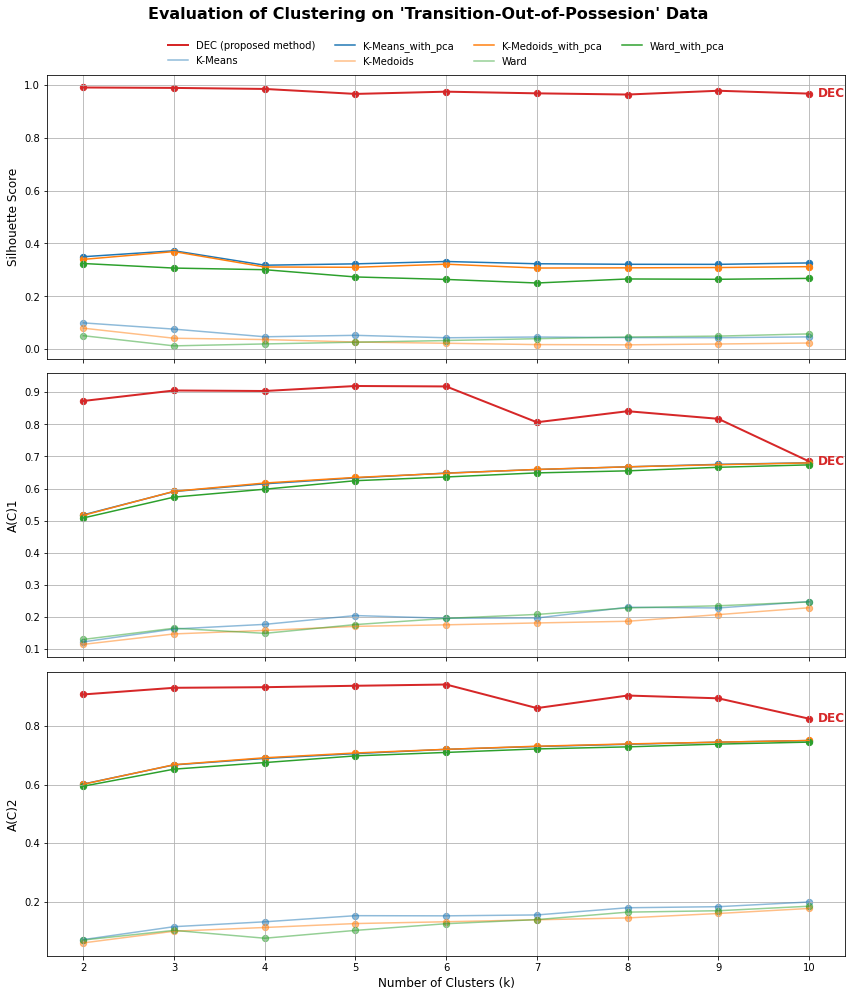

In [9]:
df = results_zscore_df.copy()

# Define mapping
old_methods = ['dec', 'kmeans', 'kmeans_pca', 'kmedoids', 'kmedoids_pca', 'ward', 'ward_pca']
new_methods = ['DEC (proposed method)', 'K-Means', 'K-Means_with_pca', 'K-Medoids', 'K-Medoids_with_pca', 'Ward', 'Ward_with_pca']
method_map = dict(zip(old_methods, new_methods))

# Apply mapping
df['method'] = df['method'].map(method_map)


# Ensure columns are correct and values are flattened
df['k'] = df['k'].astype(int)
df['silhouette_score'] = df['silhouette_score'].astype(float)
df['AC1'] = df['AC1'].astype(float)
df['AC2'] = df['AC2'].astype(float)

# Define method groups and colors
methods = ['DEC (proposed method)', 'K-Means', 'K-Means_with_pca', 'K-Medoids', 'K-Medoids_with_pca', 'Ward', 'Ward_with_pca']
base_colors = {
    'K-Means': '#1f77b4',
    'K-Medoids': '#ff7f0e',
    'Ward': '#2ca02c'
}
highlight_color = '#d62728'  # red for 'DEC (proposed method)'

# Color map with pale variants for base methods and shared colors
color_map = {
    'DEC (proposed method)': highlight_color,
    'K-Means': base_colors['K-Means'] + '80',
    'K-Means_with_pca': base_colors['K-Means'],
    'K-Medoids': base_colors['K-Medoids'] + '80',
    'K-Medoids_with_pca': base_colors['K-Medoids'],
    'Ward': base_colors['Ward'] + '80',
    'Ward_with_pca': base_colors['Ward']
}

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
metrics = ['silhouette_score', 'AC1', 'AC2']
ylabels = ['Silhouette Score', 'A(C)1', 'A(C)2']

for ax, metric, ylabel in zip(axs, metrics, ylabels):
    for method in methods:
        subset = df[df['method'] == method]
        x = subset['k'].to_numpy()
        y = subset[metric].to_numpy()
        ax.plot(x, y, label=method,
                color=color_map[method], linewidth=2 if method == 'DEC (proposed method)' else 1.5)
        ax.scatter(x, y, color=color_map[method], s=40)
        if method == 'DEC (proposed method)':
            ax.text(x[-1] + 0.1, y[-1], 'DEC', color=color_map[method],
                    fontsize=12, fontweight='bold', va='center')
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)

axs[-1].set_xlabel('Number of Clusters (k)', fontsize=12)
fig.suptitle("Evaluation of Clustering on 'Transition-Out-of-Possesion' Data", fontsize=16, fontweight='bold', y=.95)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=10, frameon=False)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()